# Anomaly Detection and Recommender Systems

## 2 Recommender Systems

"...you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings."

The MovieLens 100k Dataset (GroupLens Research) has n_u = 943 users and n_m = 1682 movies. Movies are rated on a scale of 1-5.

Our objective is to recommend movies to a user that a user has not rated, based on what we know about their preferences from movies they have rated.

### 2.1 Movie ratings dataset

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.optimize import minimize

In [2]:
data = scipy.io.loadmat('data/ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [3]:
Y = data['Y']
R = data['R']

In [4]:
Y.shape

(1682, 943)

Y is a (n_m x n_u) matrix of all users' movie ratings. Ratings are on a scale 1-5.

In [5]:
R.shape

(1682, 943)

R is a binary-valued matrix: 1 for if a movie has been rated by a user, 0 otherwise.

In [6]:
# As an example exercise, let's compute the average rating for movie 0 (Toy Story):
print('Average rating for \'Toy Story\': %.2f' %(np.mean(Y[0, R[0, :]==1])))

Average rating for 'Toy Story': 3.88


Note to self:

    Y[0, R[0, :]==1]
    
means: take 0th row of Y (i.e. ratings for Toy Story), and then from that row take columns where `R[0, :]==1`, i.e. take columns where the matching column in the zeroth row of R is 1.

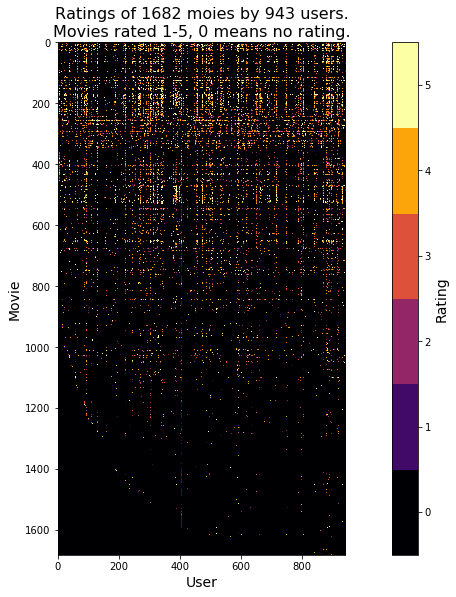

In [7]:
# Visualise ratings

plt.figure(figsize=(16.82, 9.43))
n_colors = 6

# Discrete colormap
cmap = plt.get_cmap('inferno', n_colors)
plt.imshow(Y, cmap=cmap)

# Discrete colorbar with ticks in the middle of colours
# adapted from https://stackoverflow.com/a/50314773/8291169
cbar = plt.colorbar()
tick_locs = (np.arange(n_colors) + 0.5)*(n_colors-1)/n_colors
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(n_colors))
cbar.set_label('Rating', fontsize=14)

plt.ylabel('Movie', fontsize=14)
plt.xlabel('User', fontsize=14)
plt.title('Ratings of 1682 moies by 943 users.\nMovies rated 1-5, 0 means no rating.', fontsize=16)
plt.show()

### 2.2 Collaborative filtering learning algorithm

In [8]:
# Load pre-trained weights
data = scipy.io.loadmat('data/ex8_movieParams.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [9]:
# Move feature vectors
X = data['X']
X.shape

(1682, 10)

Each of the 1682 movies has 10 features.

In [10]:
# User parameters
Theta = data['Theta']
Theta.shape

(943, 10)

In [11]:
# Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

In [12]:
def coFi_cost_func(params, Y, R, num_users, num_movies, num_features, Lambda):
    '''
    coFi_cost_func(X, Theta, Y, R, num_users, num_movies, num_features, Lambda)
    Returns the cost and gradient for the collaborative filtering problem.
    '''
    
    # Reshape params back into X, Theta
    X = np.reshape(params[:num_movies*num_features], (num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features), order='F')

    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    ## Compute cost
    J = 0.5 * np.sum(((np.dot(X, Theta.T) - Y) * R)**2 )
    
    # If Lambda != 0
    J += Lambda/2 * np.sum(Theta[:]**2)
    J += Lambda/2 * np.sum(X[:]**2)
    

    ## Compute gradient
    
    # X_grad
    X_grad = np.dot((np.dot(X, Theta.T) - Y) * R, Theta) + Lambda * X
        
    # Theta_grad
    Theta_grad = np.dot(((np.dot(X, Theta.T) - Y) * R).T, X) + Lambda * Theta

    grad = np.append(X_grad.flatten(order='F'), Theta_grad.flatten(order='F'))
    
    return J, grad

#### 2.2.1 Collaborative filtering cost function

In [13]:
# Evaluate cost function
params = np.append(X.flatten(order='F'), Theta.flatten(order='F'))
J, grad = coFi_cost_func(params, Y, R, num_users, num_movies, num_features, 0)

print('Cost at loaded parameters:', J)
print('   (this value should be about 22.22)')

Cost at loaded parameters: 22.2246037257
   (this value should be about 22.22)


#### 2.2.2 Collaborative filtering gradient

In [14]:
# Gradient calculation implemented in coFi_cost_func()

Write a couple of functions to do gradient checking...

In [15]:
def compute_numerical_gradient(J, params):
        
    num_grad = np.zeros(params.shape)
    perturb = np.zeros(params.shape)
    
    e = 1e-4

    for p in range(params.size):
        perturb[p] = e

        p1 = params - perturb
        p2 = params + perturb
        
        loss1 = J(p1)[0]
        loss2 = J(p2)[0]
        
        num_grad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    
    return num_grad

In [16]:
def check_cost_function(Lambda=0):
    '''
    Creates a collaborative filering problem 
    to check cost function and gradients. Outputs the 
    analytical gradients produced by coFi_cost_func() and numerical gradients.
    These two gradient computations should result in very similar values.
    '''

    ## Create some sample data
    # Movie features
    X_t = np.random.rand(4, 3) # n_m x n_features

    # User paramaters
    Theta_t = np.random.rand(5, 3) # n_u x n_features
    
    # Movie ratings by users
    Y = np.dot(X_t, Theta_t.T) # n_m x n_u
    
    # Set some random elements of Y to zero to simulate unrated movies
    Y[np.random.random_sample(Y.shape) > 0.5] = 0
    
    # Create binary-valued matrix: 1 for if a movie has been rated by a user, 0 otherwise
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
  

    ## Run Gradient Checking
    X = np.random.normal(size=X_t.shape)
    Theta = np.random.normal(size=Theta_t.shape)
    params = np.append(X.flatten(order='F'), Theta.flatten(order='F'))
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    def cost_func(params_temp):
        return coFi_cost_func(params_temp, Y, R, num_users, num_movies, num_features, Lambda)

    # Analytical gradient
    cost, grad = cost_func(params)
    
    # Numerical gradient
    num_grad = compute_numerical_gradient(cost_func, params)

    diff_grad = grad - num_grad

    # Print in nice columns using a format string https://stackoverflow.com/a/9996049/8291169
    print("{: <25} {: <25} {: <25}".format('Analytical gradient', 'Numerical gradient', 'Difference'))
    for i in range(grad.size):
        print("{: <25} {: <25} {: <25}".format(grad[i], num_grad[i], diff_grad[i]))

"If your implementation is correct, you should find that the analytical and numerical gradients match up closely."

In [17]:
check_cost_function()

Analytical gradient       Numerical gradient        Difference               
-0.16692390069961158      -0.16692390070183194      2.220362782523466e-12    
6.61632593541372          6.616325935411282         2.4371615836571436e-12   
-0.08356692252335726      -0.08356692252853293      5.17566545177317e-12     
4.665516705632295         4.665516705637529         -5.234035427292838e-12   
0.9571243334610723        0.9571243334605128        5.594413821086164e-13    
-2.8896529120020875       -2.8896529120103764       8.288925101851419e-12    
1.033498519404728         1.0334985194049295        -2.0161650127192843e-13  
-1.4173909835125045       -1.4173909835157872       3.282707439211663e-12    
0.927000999543425         0.9270009995443473        -9.2237328885858e-13     
-5.291309339614712        -5.291309339616745        2.0330404026935867e-12   
0.7540781547918886        0.7540781547898945        1.9940715745292437e-12   
-1.9914000921633834       -1.9914000921694708       6.0873528440

#### 2.2.3 Regularized cost function

In [18]:
# Regularistion implemented in coFi_cost_func

# Check regularised cost function works
J = coFi_cost_func(params, Y, R, num_users, num_movies, num_features, 1.5)[0]

print('Cost with Lambda = 1.5:', J)
print('   (this value should be about 31.34)')

Cost with Lambda = 1.5: 31.3440562443
   (this value should be about 31.34)


#### 2.2.4 Regularized gradient

In [19]:
# Regularistion implemented in coFi_cost_func

# Check regularised gradient works
check_cost_function(1.5)

Analytical gradient       Numerical gradient        Difference               
1.061077699534459         1.061077699535673         -1.2139178551251462e-12  
-0.748694846306412        -0.7486948462798182       -2.659383824266115e-11   
1.5515531502816404        1.551553150260787         2.0853319071534315e-11   
1.6466708959019845        1.646670895905089         -3.1046276660617877e-12  
-5.221224175335034        -5.221224175340211        5.17719200843203e-12     
0.21663407444602012       0.21663407444805216       -2.032041201971424e-12   
-0.06858132875228759      -0.06858132875819933      5.911743317099649e-12    
-4.105072813262959        -4.105072813267441        4.481748305806832e-12    
5.0050122135716135        5.00501221360139          -2.97761815204467e-11    
1.6770835219510418        1.6770835219404034        1.0638379066563175e-11   
-3.471034358665923        -3.47103435867524         9.316991622654314e-12    
-0.3799115879507343       -0.37991158793104773      -1.968658569

### 2.3 Learning movie recommendations

Load some ratings for a new user, and make movie recommendations for that user.

In [20]:
# Load move IDs

# File is encoded in Latin-1
file = open('data/movie_ids.txt', encoding='ISO-8859-1')
movie_ids = file.read().splitlines()
file.close()

In [21]:
# Take a peek
movie_ids[:10]

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)']

In [22]:
new_user_ratings = np.zeros([1682, 1])

new_user_ratings[0] = 4 # Toy Story [1995]
new_user_ratings[97] = 2 # Silence of the Lambs [1991]
new_user_ratings[6] = 3 # etc...
new_user_ratings[11]= 5
new_user_ratings[53] = 4
new_user_ratings[63]= 5
new_user_ratings[65]= 3
new_user_ratings[68] = 5
new_user_ratings[182] = 4
new_user_ratings[225] = 5
new_user_ratings[354]= 5

print("{: <40} {: <6}".format('Movie', 'Rating'))
for movie in range(new_user_ratings.size):
    if new_user_ratings[movie] > 0:
        print("{: <40} {: >6}".format(movie_ids[movie], int(new_user_ratings[movie])))

Movie                                    Rating
1 Toy Story (1995)                            4
7 Twelve Monkeys (1995)                       3
12 Usual Suspects, The (1995)                 5
54 Outbreak (1995)                            4
64 Shawshank Redemption, The (1994)           5
66 While You Were Sleeping (1995)             3
69 Forrest Gump (1994)                        5
98 Silence of the Lambs, The (1991)           2
183 Alien (1979)                              4
226 Die Hard 2 (1990)                         5
355 Sphere (1998)                             5


We're now going to train the recommender system on the entire dataset, including our new user:

In [23]:
# Load data
data = scipy.io.loadmat('data/ex8_movies.mat')
Y = data['Y']
R = data['R']

In [24]:
# Add data for new user
Y = np.append(Y, new_user_ratings, axis=1)

new_user_R = np.zeros(new_user_ratings.shape)
new_user_R[new_user_ratings != 0] = 1
R = np.append(R, new_user_R, axis=1)

In [25]:
# Normalize Ratings
num_movies, num_users = Y.shape

Y_mean = np.zeros([num_movies, 1])
Y_norm = np.zeros(Y.shape)

for i in range(num_movies):
    # users who have rated movie i
    idx = np.where(R[i, :] == 1)
    
    # mean rating for movie i
    Y_mean[i] = np.mean(Y[i, idx])
    
    # normalise ratings for movie i
    Y_norm[i, idx] = Y[i, idx] - Y_mean[i]

In [26]:
# Set random initial parameters X, Theta
num_features = 10
X = np.random.normal(size=(num_movies, num_features))
Theta = np.random.normal(size=(num_users, num_features))
initial_params = np.append(X.flatten(order='F'), Theta.flatten(order='F'))
Lambda = 10

In [27]:
def cost_func(params):
    return coFi_cost_func(params, Y_norm, R, num_users, num_movies, num_features, Lambda)

res = minimize(fun=cost_func, x0=initial_params, method='CG', jac=True, options={'maxiter':100})

In [28]:
res

     fun: 38979.18419811988
     jac: array([ 0.07697576,  0.15099411, -0.05063241, ..., -0.00326271,
       -0.06996989,  0.01324413])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 154
     nit: 100
    njev: 154
  status: 1
 success: False
       x: array([-0.08932315,  0.44940504, -0.39911877, ...,  0.48575726,
        0.68234979,  0.22357107])

In [29]:
# Recover X, Theta
params = res.x

X = np.reshape(params[:num_movies*num_features], (num_movies, num_features), order='F')
Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features), order='F')

In [30]:
# Make predictions for new user
pred = np.dot(X, Theta.T)
new_user_predictions = np.reshape(pred[:, -1], (num_movies, 1))
new_user_predictions += Y_mean

In [31]:
# Get inidices (movie IDs) of top predictions for new user
new_user_pred_idx = np.argsort(new_user_predictions, axis=0)
# Make highest ratings come first
new_user_pred_idx = np.flip(new_user_pred_idx, axis=0)

In [32]:
print("{: <55} {: >20}".format('Recommended movie', 'Predicted rating'))
for i in range(10):
    print("{: <55} {: >20,.2}".format(movie_ids[int(new_user_pred_idx[i])],
                                      float(new_user_predictions[int(new_user_pred_idx[i])])))

Recommended movie                                           Predicted rating
1293 Star Kid (1997)                                                     5.0
1189 Prefontaine (1997)                                                  5.0
1599 Someone Else's America (1995)                                       5.0
1201 Marlene Dietrich: Shadow and Light (1996)                           5.0
1122 They Made Me a Criminal (1939)                                      5.0
814 Great Day in Harlem, A (1994)                                        5.0
1653 Entertaining Angels: The Dorothy Day Story (1996)                   5.0
1467 Saint of Fort Washington, The (1993)                                5.0
1536 Aiqing wansui (1994)                                                5.0
1500 Santa with Muscles (1996)                                           5.0


**Note:** The answers in ex8.pdf Fig 4 are incorrect. The predictions I have made above are correct. From an [official announcement in the course forums](https://www.coursera.org/learn/machine-learning/discussions/weeks/9/threads/wGS9WEPDEeaL_xIEq4QdBw) (link only accessible if you are signed up to the course):

>Q2) Why don't my movie recommendations match Figure 4 in ex8.pdf?

>Figure 4 in ex8.pdf was created using a defective version of ex8_cofi.m. The error has been repaired, but ex8.pdf has not been re-generated yet.

>Your results should look something like this, but the specific movies will vary due to the random initialization of X and Theta.

> 
```
Top recommendations for you:
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Someone Else's America (1995)
```